# Fetching the Dataset

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# ! cp /content/drive/MyDrive/Dataset.zip Dataset.zip

In [3]:
# !unzip -q Dataset.zip -d Dataset/

# Importing Dependencies

In [4]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Dense, 
    GlobalAveragePooling2D, 
    Dropout, 
    InputLayer, 
    Flatten
)
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import ResNet50

# Scikit-learn
from sklearn.metrics import (
    accuracy_score, 
    f1_score, 
    roc_auc_score, 
    recall_score, 
    precision_score, 
    confusion_matrix, 
    roc_curve
)

# Visualization
import seaborn as sns

2025-11-09 10:36:22.467404: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-11-09 10:36:22.467524: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-11-09 10:36:22.577175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Constants

In [ ]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 3
PATH = 'data\Freshwater Fish Disease Aquaculture in south asia'  # Update with your dataset path

# Importing data into a TensorFlow dataset object

In [6]:
dataset = image_dataset_from_directory(
    PATH + 'Train/',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1747 files belonging to 7 classes.


In [7]:
class_names = dataset.class_names
class_names

['Bacterial Red disease',
 'Bacterial diseases - Aeromoniasis',
 'Bacterial gill disease',
 'Fungal diseases Saprolegniasis',
 'Healthy Fish',
 'Parasitic diseases',
 'Viral diseases White tail disease']

# Visualizing the first batch of images.

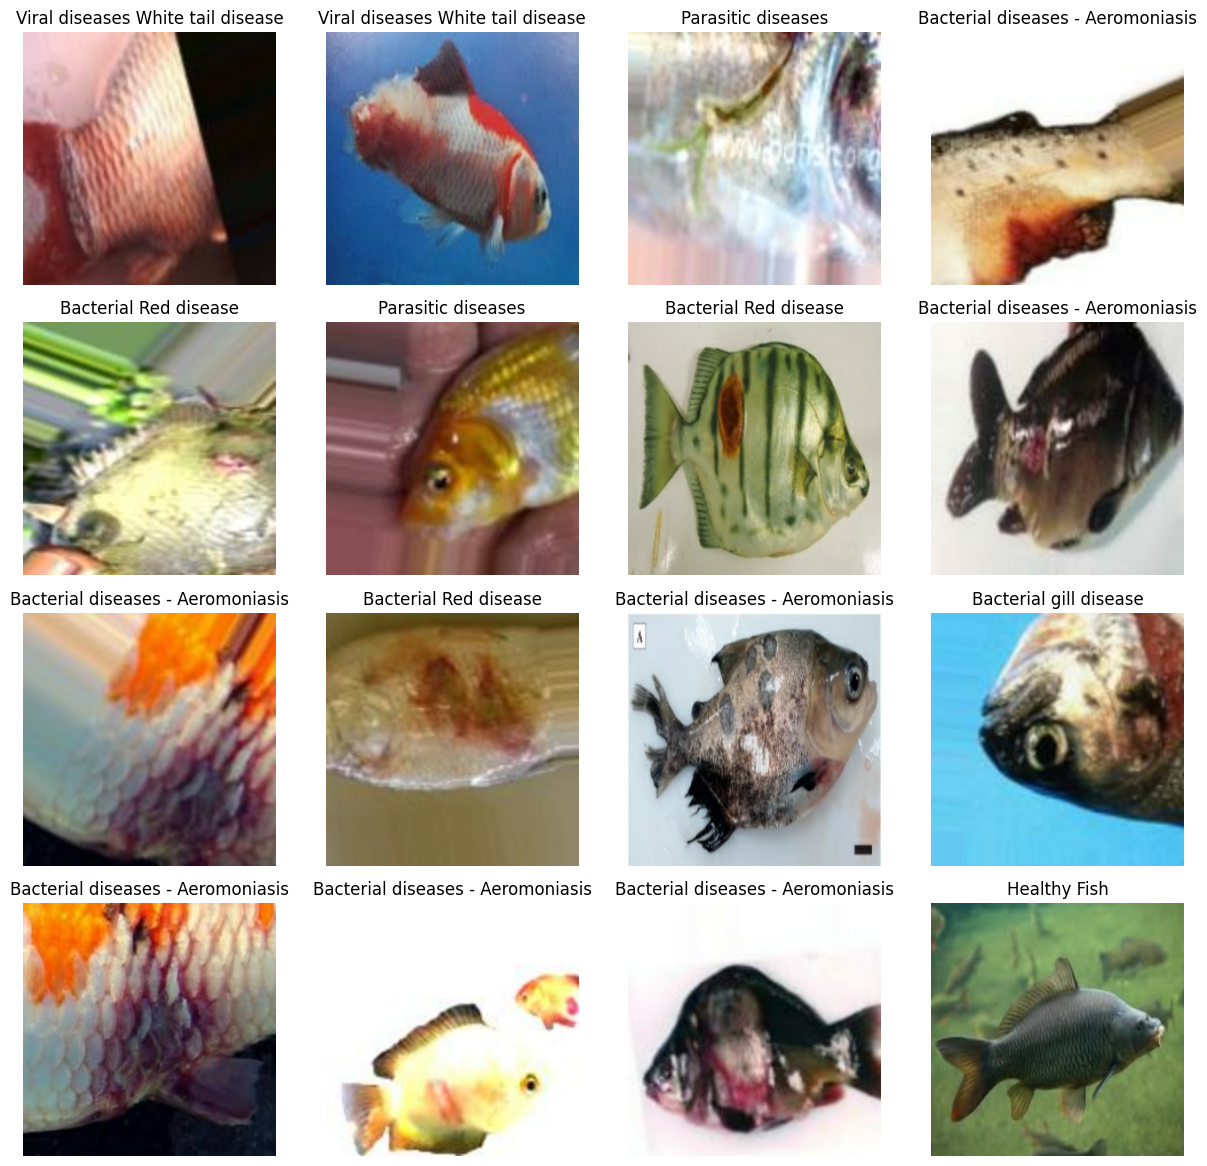

In [8]:
plt.figure(figsize=(12, 12))
for batch_images, batch_labels in dataset.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(batch_images[i].numpy().astype("uint8"))
        plt.title(class_names[batch_labels[i]])
        plt.tight_layout()
        plt.axis("off")


# Splitting Dataset into Training, Validation, and Testing

In [9]:
TRAIN_SIZE, VALIDATION_SIZE= 0.9, 0.1

In [10]:
train_batch = int(len(dataset) * TRAIN_SIZE)
train_ds = dataset.take(train_batch)

In [11]:
val_batch = int(len(dataset) * VALIDATION_SIZE)
validation_ds = dataset.skip(train_batch).take(val_batch)

# Building Model

## Resizing and Normalization Layer

In [12]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255),
])

## Data Augmentation

In [13]:
data_augmentation = tf.keras.Sequential([
  layers.RandomRotation(0.2),
])

## Applying Data Augmentation to Train Dataset

In [14]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

In [15]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = len(class_names)

# ResNet50
base_model = tf.keras.applications.ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=input_shape
)

base_model.trainable = False

# Model
model = Sequential([
    base_model,
    Flatten(),
    Dense(384, activation='relu'),
    Dense(n_classes, activation='softmax') 
])


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


We use `adam` Optimizer, `SparseCategoricalCrossentropy` for losses, `accuracy` as a metric

In [16]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

Creating a checkpoint to save the model with the best score.

In [17]:
callback = [
    tf.keras.callbacks.ModelCheckpoint(filepath='model.keras')
]

## Training

In [18]:
history = model.fit(
    train_ds,
    batch_size = BATCH_SIZE,
    validation_data = validation_ds,
    verbose = 1,
    epochs = EPOCHS,
    callbacks = callback
)

Epoch 1/3
 2/49 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step - accuracy: 0.1328 - loss: 23.5165 

I0000 00:00:1762684614.778601     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


49/49 ━━━━━━━━━━━━━━━━━━━━ 32s 350ms/step - accuracy: 0.3070 - loss: 35.8857 - val_accuracy: 0.6250 - val_loss: 4.2148
Epoch 2/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 287ms/step - accuracy: 0.7027 - loss: 2.5048 - val_accuracy: 0.6562 - val_loss: 3.0296
Epoch 3/3
49/49 ━━━━━━━━━━━━━━━━━━━━ 14s 285ms/step - accuracy: 0.7482 - loss: 1.6371 - val_accuracy: 0.7937 - val_loss: 1.1053


## Loading Model

In [19]:
model = load_model('model.keras')

## Evaluation

In [20]:
test_dataset = image_dataset_from_directory(
    PATH + 'Test/',
    seed = 42,
    shuffle = True,
    image_size = (IMAGE_SIZE , IMAGE_SIZE),
    batch_size = BATCH_SIZE
).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 697 files belonging to 7 classes.


### Predict

In [21]:
all_predictions = []
all_labels = []
for images, labels in test_dataset:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    all_predictions.extend(predicted_classes)
    all_labels.extend(labels.numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


### Metrices

In [22]:
accuracy = accuracy_score(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')

print("Accuracy: ", accuracy)
print("F1 Score: ", f1)
print("Recall: ", recall)
print("Precision: ", precision)

Accuracy:  0.8393113342898135
F1 Score:  0.840112253877252
Recall:  0.8393113342898135
Precision:  0.8475203027240763


### Confusion Matrix

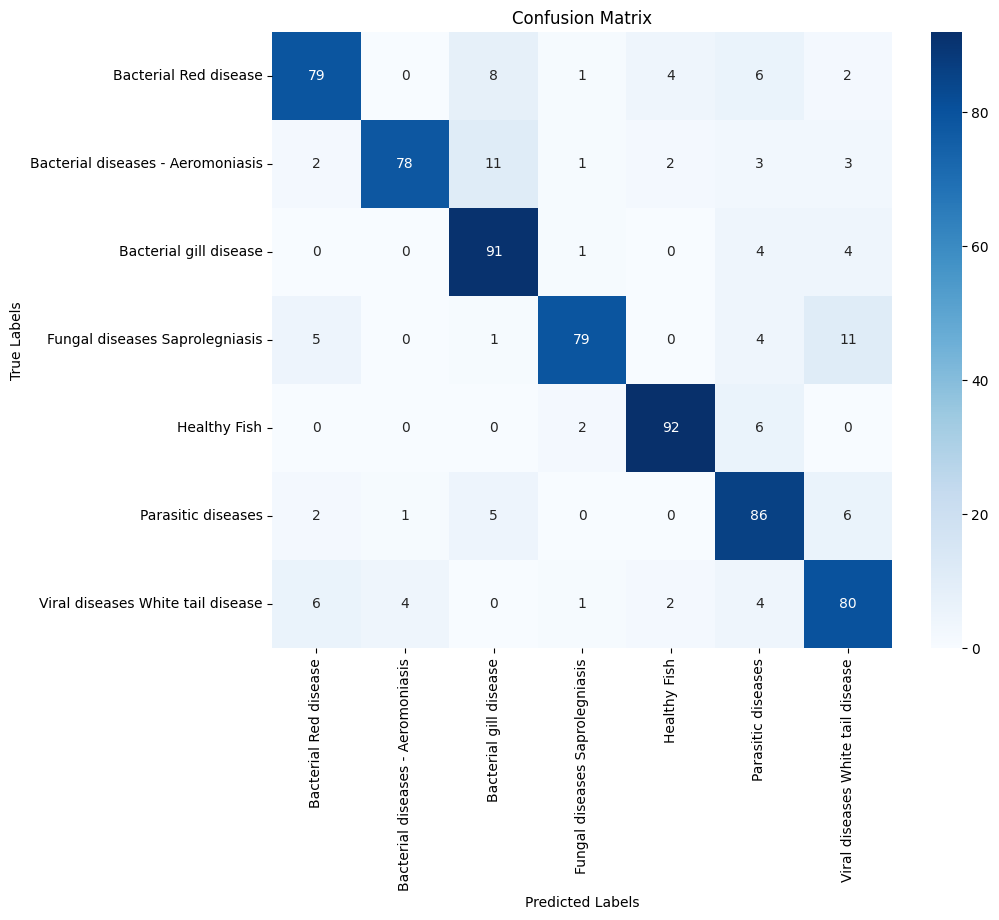

In [23]:
conf_matrix = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('Confusion Matrix.png', dpi = 300)
plt.show()


# Plotting the Accuracy and Loss Curves

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

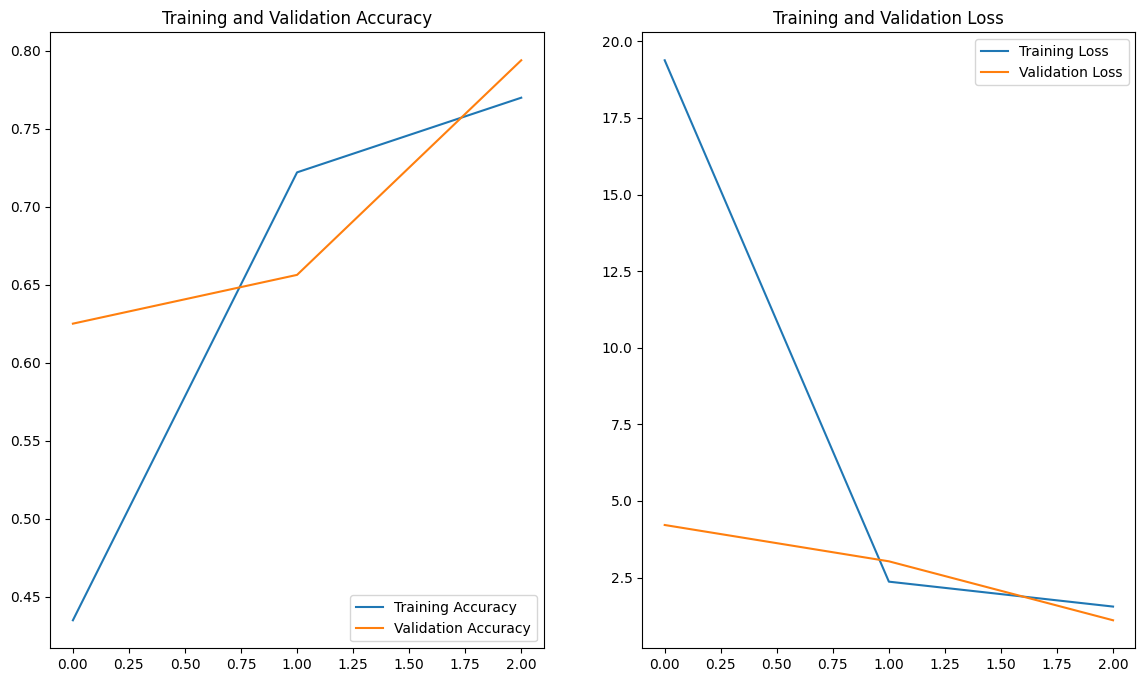

In [25]:
plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.savefig('curves.png', dpi = 300)
plt.show()

# Inference



## Inference Function

In [26]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

## Running Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


<Figure size 640x480 with 0 Axes>

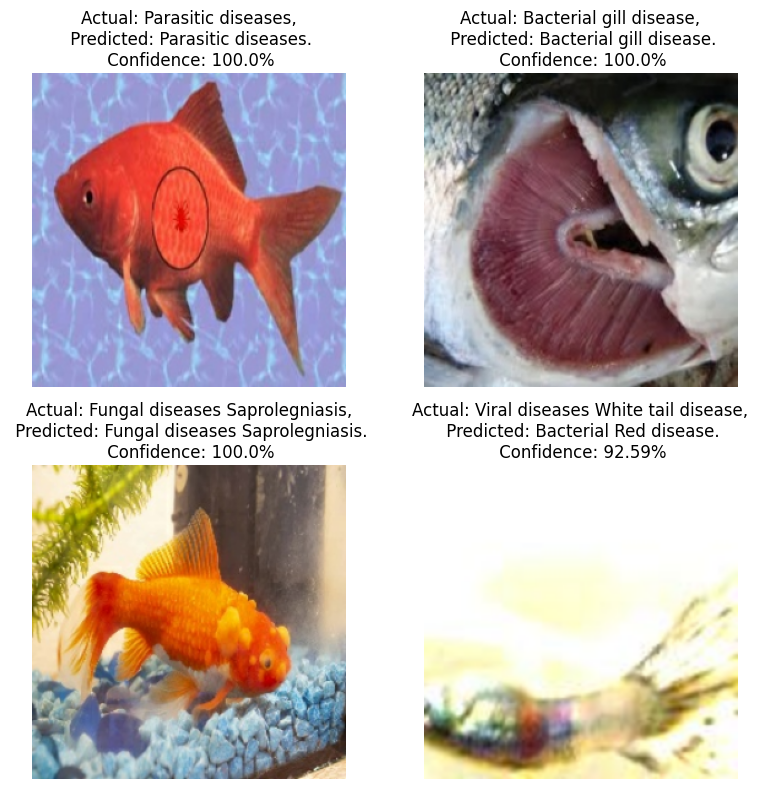

In [27]:
plt.clf()
plt.figure(figsize=(8, 8))
for images, labels in test_dataset.take(6):
    for i in range(4):
        ax = plt.subplot(2, 2, i + 1)
        if i < len(images):
            ax.imshow(images[i].numpy().astype("uint8"))

            predicted_class, confidence = predict(model, images[i])
            actual_class = class_names[labels[i]]

            ax.set_title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
            ax.axis("off")
plt.tight_layout()
plt.show()


# Inference from File

In [28]:
def sample_predict(model, image_path):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(256, 256))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Create a batch
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    img = Image.open(image_path)
    plt.imshow(img)
    print("Predicted class:", predicted_class)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted class: Bacterial Red disease


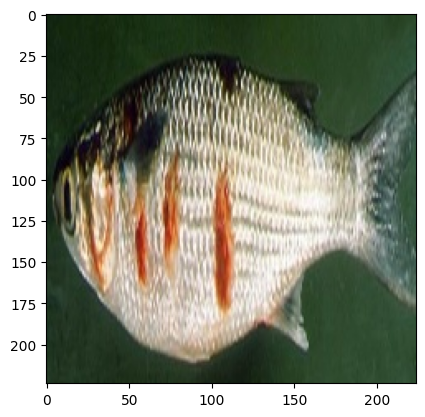

In [ ]:
sample_predict(model, 'data\Freshwater Fish Disease Aquaculture in south asia\Test\Bacterial Red disease\Bacterial Red disease (1).jpeg')